# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer 
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [116]:
data = pd.read_csv("adult_data_train.csv").drop(columns=["education", "marital-status"])
data

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,?,122244,9,?,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26044,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26045,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26046,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Определите количество числовых и нечисловых признаков.

In [117]:
# Определение количества числовых и нечисловых признаков
num_features = data.select_dtypes(include=['number']).shape[1]
non_num_features = data.select_dtypes(exclude=['number']).shape[1]

(num_features, non_num_features)

(7, 6)

Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

((array([19775.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,  6273.]),
  array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
  <BarContainer object of 10 artists>),
 0.7592045149153454)

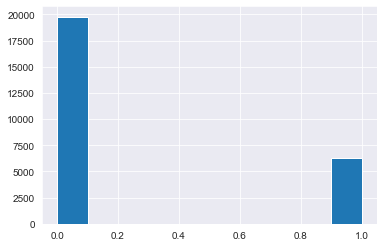

In [118]:
fig, axes = plt.subplots()
axes.hist(data["label"]), 19775/26047

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных. 

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [119]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["workclass", "occupation", "relationship", "race", "sex", "native-country", "label"]), 
                                                    data["label"], test_size=0.2, random_state=7, stratify=data["label"])
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
X_train["fnlwgt"].mean(), f1_score(y_test, knn.predict(X_test))

(189789.851281313, 0.38031088082901554)

Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [120]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"])
X_test = pd.DataFrame(X_test, columns=["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"])


knn.fit(X_train, y_train)
X_train["fnlwgt"].mean(), f1_score(y_test, knn.predict(X_test))

(0.12055313788274608, 0.5160390516039052)

Видно, что после линейной нормировки качество выросло. 

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>). 

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

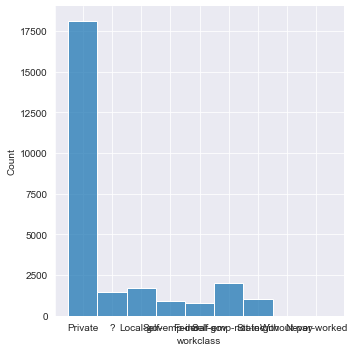

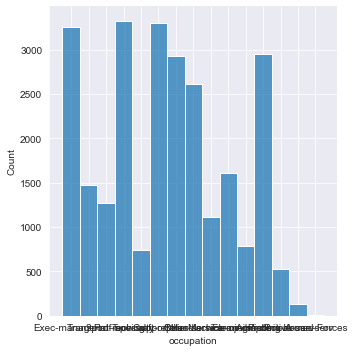

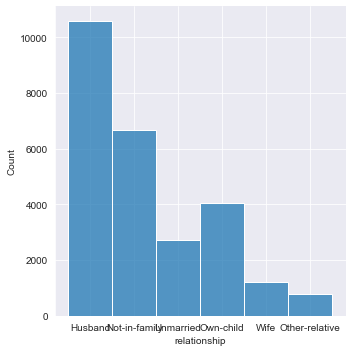

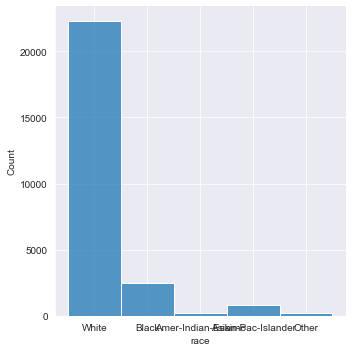

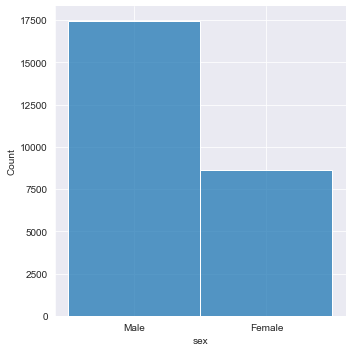

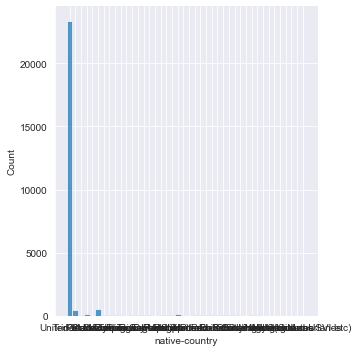

In [121]:
sns.displot(data["workclass"])
sns.displot(data["occupation"])
sns.displot(data["relationship"])
sns.displot(data["race"])
sns.displot(data["sex"])
sns.displot(data["native-country"])
#sns.barplot(data[["workclass", "occupation", "relationship", "race", "sex", "native-country"]])

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [122]:
NaN_in_data = data == '?'
NaN_in_data["Any_NaN"] = False

for col in NaN_in_data:
    NaN_in_data["Any_NaN"] |= NaN_in_data[col]
    
data_with_NaN = data.loc[NaN_in_data["Any_NaN"]]
len(data_with_NaN), data_with_NaN.head()

(1914,
     age workclass  fnlwgt  education-num occupation   relationship   race  \
 2    20         ?  122244              9          ?  Not-in-family  White   
 9    28         ?  149646             10          ?      Own-child  White   
 14   60         ?  251572              9          ?  Not-in-family  White   
 15   34         ?  317219             10          ?           Wife  White   
 40   36         ?   94954             11          ?  Not-in-family  White   
 
        sex  capital-gain  capital-loss  hours-per-week native-country  label  
 2   Female             0             0              28  United-States      0  
 9   Female             0             0              20              ?      0  
 14    Male             0             0              35         Poland      0  
 15  Female             0             0              20  United-States      1  
 40  Female             0             0              20  United-States      0  )

Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них. 

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [123]:
# Удаление строк, содержащих пропуски (предполагается, что пропуски обозначены как '?')
data_nanless = data.replace('?', pd.NA).dropna()

# Произведение one-hot кодирования нечисловых признаков
data_one_hot_encoded = pd.get_dummies(data_nanless, drop_first=True)

# Определение общего числа полученных признаков
total_features = len(data_one_hot_encoded.columns)
total_features

76

Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [124]:
X_train, X_test, y_train, y_test = train_test_split(data_nanless.drop(columns=["label"]), 
                                                    data_nanless["label"], test_size=0.2, random_state=7, stratify=data_nanless["label"])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn.fit(X_train, y_train)
f1_score(y_test, knn.predict(X_test))

ValueError: could not convert string to float: 'Private'

Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [ ]:
data = data.replace("?", np.nan)

for col in data.columns:
    data[col] = data[col].fillna(data[col].mode()[0])

Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [ ]:
data = pd.get_dummies(data, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["label"]), data["label"], test_size=0.2, random_state=7, stratify=data["label"])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn.fit(X_train, y_train)
f1_score(y_test, knn.predict(X_test))

## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.

In [ ]:
data_train = pd.read_csv("adult_data_train.csv")
data_reserved = pd.read_csv("adult_data_reserved.csv")
#data_train

In [ ]:
# удаление признаков
deletable = ["education", "marital-status"]
data_train =data_train.drop(columns=deletable)
data_reserved = data_reserved.drop(columns=deletable)

data_train, data_reserved

In [ ]:
# заполнение пустых признаков
data_train = data_train.replace("?", np.nan)
data_reserved = data_reserved.replace("?", np.nan)

for col in data_train.columns:
    data_train[col] = data_train[col].fillna(data_train[col].mode()[0])
    
for col in data_reserved.columns:
    data_reserved[col] = data_reserved[col].fillna(data_reserved[col].mode()[0])
    
# one-hot
data_train = pd.get_dummies(data_train, drop_first=True)
data_reserved = pd.get_dummies(data_reserved, drop_first=True)

# split
X_train, y_train = data_train.drop(columns=["label"]), data_train["label"]

# Добавление колонок в тестовую выборку
for i, col in enumerate(X_train.columns):
    if col not in data_reserved.columns:
        data_reserved.insert(loc=i, column=col, value=0)

print(data_train)
        
# scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
data_reserved = scaler.transform(data_reserved)

In [ ]:
%%time
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
f1_score(y_train, mlp.predict(X_train))

In [ ]:
print(list(mlp.predict(data_reserved)), sep="\n")